# MMD net 

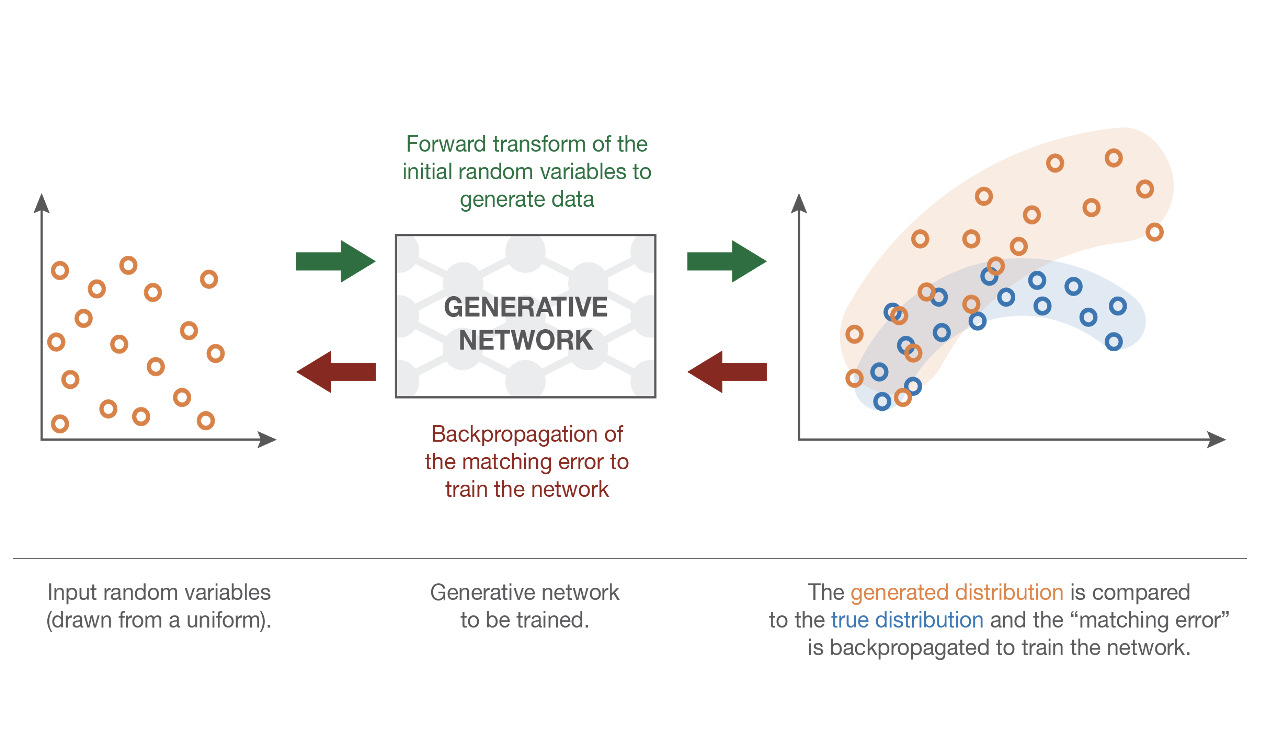

- the generated distribution is compared to the true distribution


- matching error: MMD or EMD

    MMD (maximum mean discrepancy): a perfectly backpropagatable distance between distributions
    
    EMD (earth mover's distance): hard to backpropagate

# GAN (generative adversarial network)

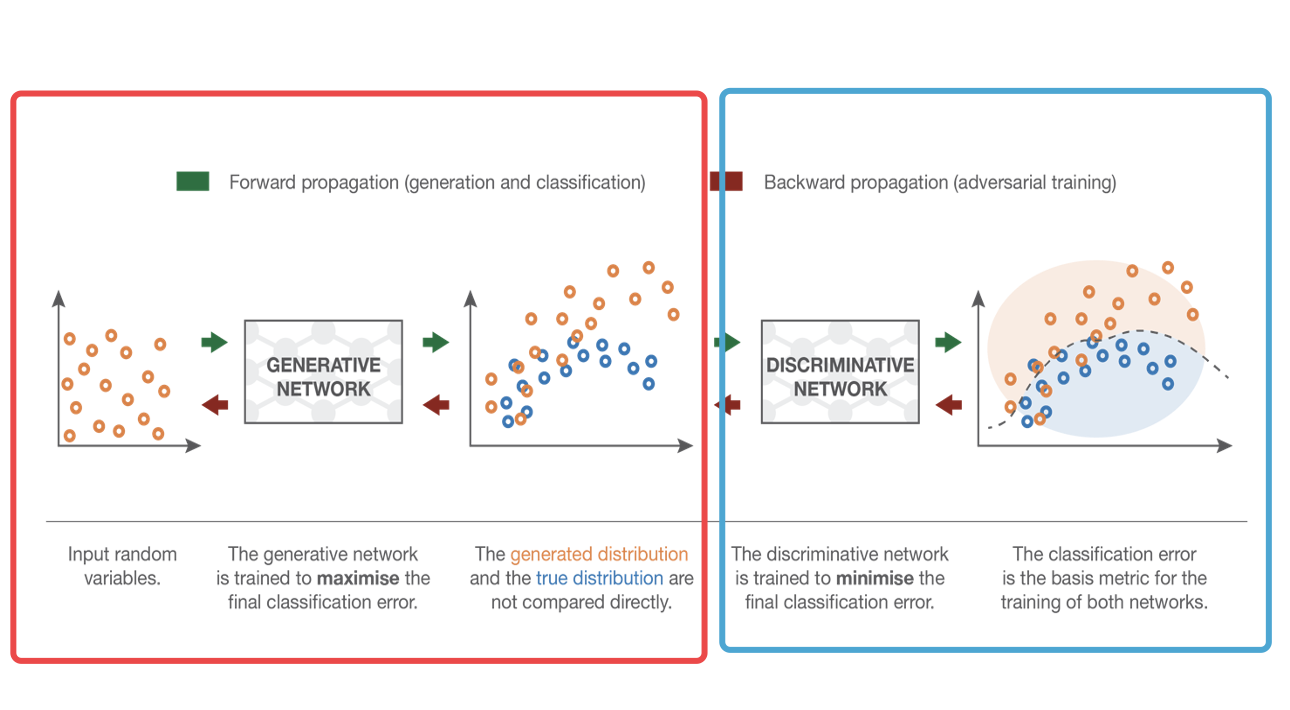

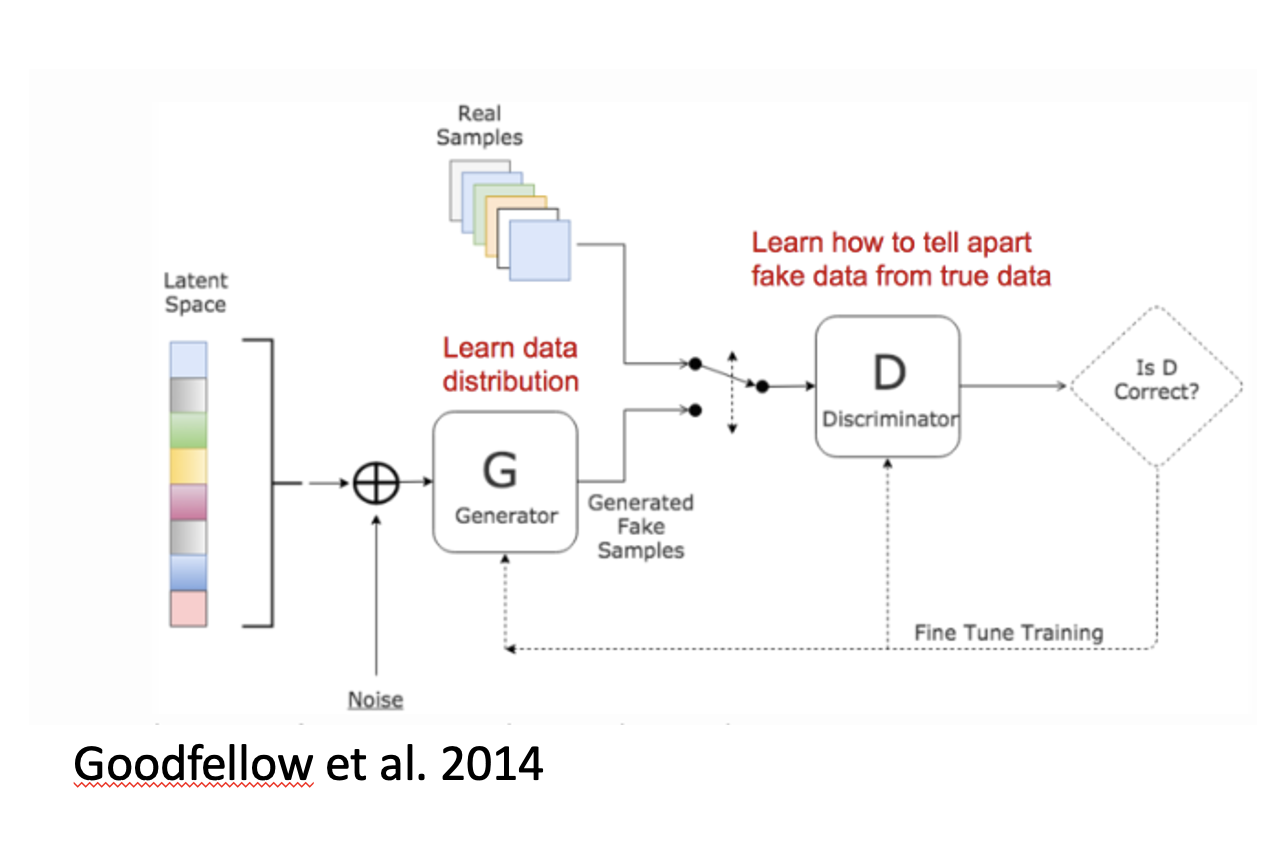

## 2 networks

- generator: transforms random noise into sample from target distribution


- discriminator: distinguish between generated (fake) samples and real samples


- 2 nets is adversarial, play a **minimax** game 极小化极大
    
    generator: try to maximize loss, fool the discriminator
    
    discriminator: try to minimize loss, catch the generator
    
 
- **indirect** way of matching distributions

minimax: minimize possible loss for a worse case scenario

maximin: maximize minimum gain

## loss function

$p_z$: data distribution over noise input $z$

$p_g$: generated data distribution over fake sample $g$

$p_r$: true data distribution over real sample $x$

- minimax game: 

$$
\min_G \max_D L(D, G) = \underset{x\sim p_r(x)}{\mathbb{E}} \log D(x) + \underset{z\sim p_z(z)}{\mathbb{E}}\log (1- D(G(z)))
\\[1em]
= \underset{x\sim p_r(x)}{\mathbb{E}}\log D(x) +\underset{x\sim p_g(x)} \log (1-D(x))
$$

- generator wants to fool discriminator: maximize discriminator's loss


1. maximize loss of discriminator's answer (1) on real samples
    
    $$
    \mathbb{E}_{x\sim p_r(x)} \left [ \log D(x) \right ]
    $$
    
    expectation over real sample $x$ of log of answer D of x,
    
    discriminator hope D(x) to be 1 so $\log D(x)=0 \Rightarrow loss=0$
    

2. maximize loss of discriminator's answer (0) on fake samples

    $$
    \mathbb{E}_{z\sim p_z(z)} \left [ \log (1-D(G(z))) \right ]
    $$
    
    expectation over noise input $z$ of log of (1 - answer D of G(z)),
    
    discriminator hope D(G(z)) to be 0 so $1-\log D(G(z))=0 \Rightarrow loss=0$


# problems with GAN

## vanishing gradient

### when generator is bad

- when generated data is very far from training data,

    the 2 distributions are far away, discriminator can be very good
    

- because of small gradients, generator can't update parameters to learn well

- take gradient of loss of fake examples w.r.t generator

$$
\nabla _{\theta_G} \mathbb{E} _{z \sim p(z)} \left [ \log (1 - D_{\theta _D}(G_{\theta_G }(z))) \right ] = \mathbb{E} _{z \sim p(z)} \left [ \frac{1}{1-\sigma_{\theta_D (s)}} (-\sigma ' \theta_D (s))|_{s = G_{\theta_G}(z)} \nabla _{\theta_G}G_{\theta_G}(z)\right ]
$$

- what happens when D is very confident a point is fake?

    sigmoid $\sigma = \sigma(D(G(z))) \rightarrow 0$ is small
    
    $\sigma'  \rightarrow 0$ is small
    
    this term $\frac{1}{1-\sigma} \cdot (-\sigma')=\frac{1}{1-0} \cdot 0 \rightarrow 0$
    
    so gradient of generator is vanishing

#### solution: alternative minimization

- instead of using 1 - discriminator value of generated data

$$
J^{(G)}(G) = \mathbb{E}_{z\sim p_z(z)} \log (1-D(G(z)))
$$


- we use **negative** discriminator value of generated data, maximize a **non-saturating loss function**

$$
J^{(G)}(G) = -\mathbb{E}_{z\sim p_z(z)} \log D(G(z))
$$   

the first term in gradient becomes $\frac{1}{\sigma} \cdot (-\sigma') = \frac{1}{0} \cdot (0) = \infty \cdot 0$ not $\rightarrow 0$


- but now generator's loss is different from discriminator's loss, not a minimax game anymore

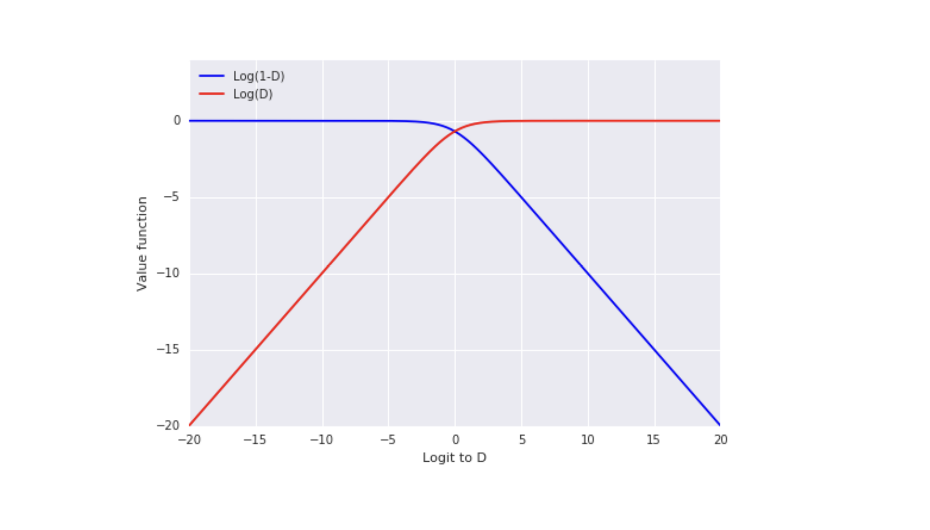

- a figure compare minimax loss function to non-saturating function

    y: value of loss function
    
    x: logits to discriminator ($\sigma$)

- minimax (blue line): 

    - left half, $\sigma \approx 0$: has extremely small gradient when D is confident the point is fake 

    this is bad because that is precisely when G needs gradient signal most to improve performance


- non-saturating (red line)

    - left half, $\sigma \approx 0$: instead, has high gradient when D is confident the point is fake 
    
    - right half, $\sigma \approx 1$: has extremely small gradient when D is confident the point is real
    
    this doesn't matter because this isn't the term D is optimizing for fake points

### when discriminator is good

- a problem that regardless what generator do, vanishing gradient for generator when discriminator gets good

#### solution: Wasserstein distance (WGAN)

1. take off sigmoidal decision layer, discriminator don't give a decision 0 for fake data and 1 for real data

    instead outputs value of **witness function**, a low value for fake data, a high value for real data

    witness function can be learned by discriminator

2. after every gradient update to witness function f, **clamp weights** to a small fixed range
    

3. new loss function doesn't have logarithm, just the difference of expected values

$$
L(p_r, p_g) =W(p_r, p_g) = \max _{w \in W} \mathbb{E} _{x \sim p_r} f_w(x)  -\mathbb{E} _{z \sim p_r(z)}  f_w(g_{\theta}(z)) 
$$

## mode collapse

- mode collapse: generator always generate same data, lack of diversity


- generator can fool the discriminator by memorizing a small number of images

### solution

1. feature matching

    we don't need to measure difference between 2 distributions **overall**

    we can just measure **statistics** of distributions e.g., does generated mean = real mean?

$$
\left\|\mathbb{E} _{x \sim p_r}  f(x)  -\mathbb{E} _{z \sim p_z(z)} f(G(z))  \right\|_2^2
$$

2. minibatch discrimination

take the batch as a whole instead of one input at a time and learn relationships between pairs of samples $c(x_i, x_j)$

$$
o(x_i) = \sum_j c(x_i, x_j)
$$